In [1]:
# And for visualization on Colab install
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [2]:
!wget http://www.atarimania.com/roms/Roms.rar
!mkdir /content/ROM/
!unrar e /content/Roms.rar /content/ROM/
!python -m atari_py.import_roms /content/ROM/

--2022-03-26 13:28:51--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar.1’

Roms.rar.1          100%[===================>]  10.61M   485KB/s    in 23s     

2022-03-26 13:29:15 (468 KB/s) - ‘Roms.rar.1’ saved [11128004/11128004]

mkdir: cannot create directory ‘/content/ROM/’: File exists

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar


Would you like to replace the existing file /content/ROM/HC ROMS.zip
11826711 bytes, modified on 2019-12-22 11:24
with a new one
11826711 bytes, modified on 2019-12-22 11:24

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Q

Program aborted
copying adventure.bin from HC ROMS/BY ALPHABET (PAL)/A-G/Adventure (PAL).bin to /usr/local/lib/

In [3]:
import random
import gym
#import math
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam

In [4]:
## Uncomment if working on Colab
from pyvirtualdisplay import Display
display = Display(visible=0, size=(600, 400))
display.start()

In [5]:
EPOCHS = 500
THRESHOLD = 10
MONITOR = True

In [6]:
class DQN():
    def __init__(self, env_string,batch_size=64, IM_SIZE = 84, m = 4):
        self.memory = deque(maxlen=5000)
        self.env = gym.make(env_string)
        input_size = self.env.observation_space.shape[0]
        action_size = self.env.action_space.n
        self.batch_size = batch_size
        self.gamma = 1.0
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.IM_SIZE = IM_SIZE
        self.m = m
       
        
        alpha=0.01
        alpha_decay=0.01
        if MONITOR: self.env = gym.wrappers.Monitor(self.env, '../data/'+env_string, force=True)
        
        # Init model
        self.model = Sequential()
        self.model.add( Conv2D(32, 8, (4,4), activation='relu',padding='valid', input_shape=(IM_SIZE, IM_SIZE, m)))
        #self.model.add(MaxPooling2D())
        self.model.add( Conv2D(64, 4, (2,2), activation='relu',padding='valid'))
        self.model.add(MaxPooling2D())
        self.model.add( Conv2D(64, 3, (1,1), activation='relu',padding='valid'))
        self.model.add(MaxPooling2D())
        self.model.add(Flatten())
        self.model.add(Dense(256, activation='elu'))
        self.model.add(Dense(action_size, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(lr=alpha, decay=alpha_decay))
        self.model_target = tf.keras.models.clone_model(self.model)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.model.predict(state))

    def preprocess_state(self, img):
        img_temp = img[31:195]  # Choose the important area of the image
        img_temp = tf.image.rgb_to_grayscale(img_temp)
        img_temp = tf.image.resize(img_temp, [self.IM_SIZE, self.IM_SIZE],
                                   method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        img_temp = tf.cast(img_temp, tf.float32)
        return img_temp[:,:,0]

    def combine_images(self, img1, img2):
        if len(img1.shape) == 3 and img1.shape[0] == self.m:
            im = np.append(img1[1:,:, :],np.expand_dims(img2,0), axis=2)
            return tf.expand_dims(im, 0)
        else:
            im = np.stack([img1]*self.m, axis = 2)
            return tf.expand_dims(im, 0)
        #return np.reshape(state, [1, 4])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = self.model_target.predict(state)
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state)[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        #epsilon = max(epsilon_min, epsilon_decay*epsilon) # decrease epsilon
       

    def train(self):
        scores = deque(maxlen=100)
        avg_scores = []
        

        for e in range(EPOCHS):
            state = self.env.reset()
            state = self.preprocess_state(state)
            state = self.combine_images(state, state)
            done = False
            i = 0
            while not done:
                action = self.choose_action(state,self.epsilon)
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                next_state = self.combine_images(next_state, state)
                #print(next_state.shape)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                self.epsilon = max(self.epsilon_min, self.epsilon_decay*self.epsilon) # decrease epsilon
                i += reward

            scores.append(i)
            mean_score = np.mean(scores)
            avg_scores.append(mean_score)
            if mean_score >= THRESHOLD:
                print('Solved after {} trials ✔'.format(e))
                return avg_scores
            if e % 10 == 0:
                print('[Episode {}] - Average Score: {}.'.format(e, mean_score))
                self.model_target.set_weights(self.model.get_weights())

            self.replay(self.batch_size)
        
        print('Did not solve after {} episodes 😞'.format(e))
        return avg_scores



In [7]:
env_string = 'BreakoutDeterministic-v4'
agent = DQN(env_string)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
agent.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 64)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0

In [9]:
agent.model_target.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 64)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0

In [10]:
scores = agent.train()

[Episode 0] - Average Score: 3.0.
[Episode 10] - Average Score: 8.272727272727273.
[Episode 20] - Average Score: 9.571428571428571.
[Episode 30] - Average Score: 9.935483870967742.
Solved after 32 trials ✔


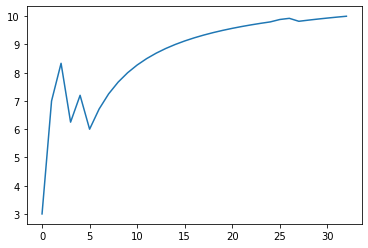

In [11]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.show()

In [12]:
agent.env.close()